In [5]:
import pandas as pd
from pathlib import Path

# 1. 模型路径配置
MODEL_DIRS = {
    "gemma3": "gemma3-results/ppl_summary_by_combo.csv",
    "phi3": "phi3-medium-results/ppl_summary_by_combo.csv",
    "phi4":   "phi4-results/ppl_summary_by_combo.csv",
    "mistral31": "mistral31-results/ppl_summary_by_combo.csv",
    "deepseekR1": "deepseekr1-results/ppl_summary_by_combo.csv"
}

rows = []

# 2. 逐模型读取
for model_name, csv_path in MODEL_DIRS.items():
    df = pd.read_csv(csv_path)

    # 只保留你关心的字段
    for _, r in df.iterrows():
        rows.append({
            "model": model_name,
            "combo": r["combo"],
            "mean_ppl": r["mean_ppl"] if model_name != "phi3" else None,
            "std_ppl": r["std_ppl"] if model_name != "phi3" else None,
        })

# 3. 合并成总表
ppl_all_models = pd.DataFrame(rows)

# 4. 保存
ppl_all_models.to_csv("all_models_mean_ppl.csv", index=False)

print(ppl_all_models)


         model    combo     mean_ppl        std_ppl
0       gemma3  AAE_AAE  1316.769218   19345.317461
1       gemma3  AAE_SAE   878.965257    8937.561955
2       gemma3  SAE_AAE  6852.975113  119833.372883
3       gemma3  SAE_SAE   847.369347   46263.678328
4         phi3  AAE_AAE          NaN            NaN
5         phi3  AAE_SAE          NaN            NaN
6         phi3  SAE_AAE          NaN            NaN
7         phi3  SAE_SAE          NaN            NaN
8         phi4  AAE_AAE  1257.412521   51858.583522
9         phi4  AAE_SAE  1155.958783   51842.032577
10        phi4  SAE_AAE  1399.103159   25973.369789
11        phi4  SAE_SAE   436.361305   23877.353656
12   mistral31  AAE_AAE   225.111085    1387.929618
13   mistral31  AAE_SAE   222.342317     658.050379
14   mistral31  SAE_AAE   631.175746    3321.062536
15   mistral31  SAE_SAE   109.512949     384.951536
16  deepseekR1  AAE_AAE   891.549471    9206.161136
17  deepseekR1  AAE_SAE   666.620557    5816.653876
18  deepseek

In [6]:
phi3_long = pd.read_csv("phi3-medium-results/ppl_scores_long.csv")
phi3_summary_new = (
    phi3_long
    .groupby("combo")["ppl_cont"]
    .agg(mean_ppl="mean", std_ppl="std")
    .reset_index()
)

phi3_summary_new["model"] = "phi3"

print("Recomputed phi3 PPL summary:")
print(phi3_summary_new)

Recomputed phi3 PPL summary:
     combo     mean_ppl       std_ppl model
0  AAE_AAE  2181.819799  37331.025211  phi3
1  AAE_SAE  2909.801780  84375.514019  phi3
2  SAE_AAE  1649.302815  31067.046086  phi3
3  SAE_SAE  1247.274165  25029.644568  phi3


In [7]:
# ========== 3. 读取总表 ==========
all_ppl = pd.read_csv("all_models_mean_ppl.csv")

# ========== 4. 删除旧的 phi3 ==========
all_ppl_no_phi3 = all_ppl[all_ppl["model"] != "phi3"]

# ========== 5. 合并新的 phi3 ==========
all_ppl_updated = pd.concat(
    [all_ppl_no_phi3, phi3_summary_new],
    ignore_index=True
)

# ========== 6. 保存 ==========
all_ppl_updated.to_csv("all_models_mean_ppl.csv", index=False)

print("Updated all_models_mean_ppl.csv saved.")

Updated all_models_mean_ppl.csv saved.


/tmp/ipykernel_74993/3689390853.py:53: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index="model", columns="combo", values="mean_ppl", aggfunc="mean")
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
f

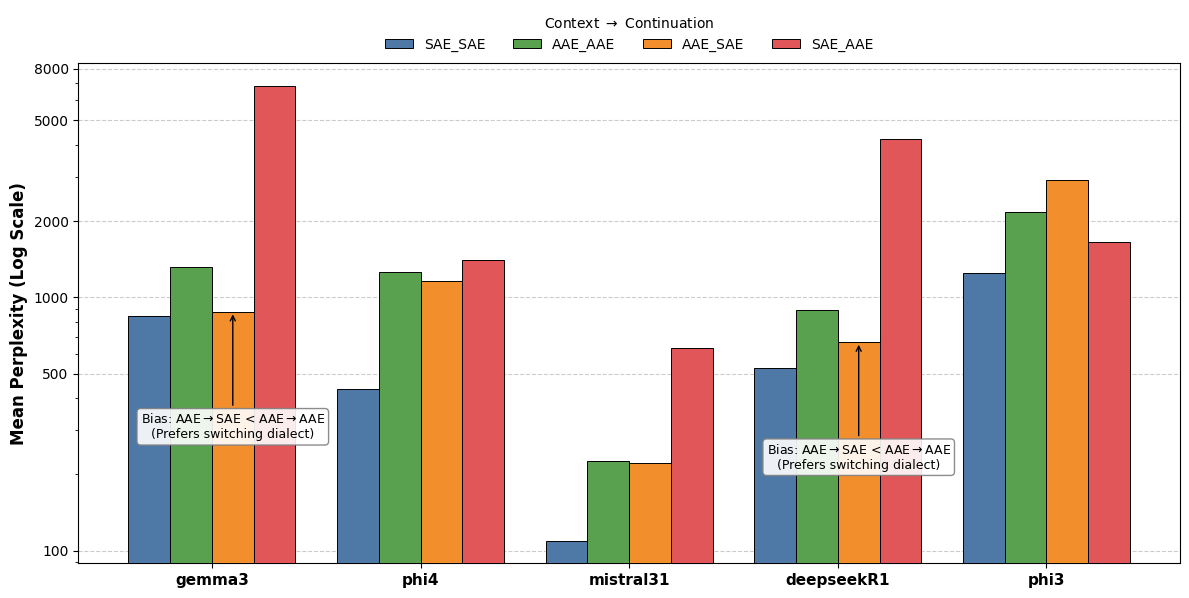

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# =========================
# 0) Config / 配置
# =========================
ALL_MODELS_MEAN_PPL_CSV = "all_models_mean_ppl.csv"
OUT_FIG = "mean_ppl_publication_ready.png"

# Fixed Order
COMBO_ORDER = ["SAE_SAE", "AAE_AAE", "AAE_SAE", "SAE_AAE"]

# Professional Academic Colors (Tableau-10 style adaptation)
# 专业的学术配色：蓝、绿、橙、红
COMBO_COLOR = {
    "SAE_SAE": "#4E79A7",  # Muted Blue (Baseline)
    "AAE_AAE": "#59A14F",  # Muted Green (Target)
    "AAE_SAE": "#F28E2B",  # Muted Orange (Bias/Correction)
    "SAE_AAE": "#E15759",  # Muted Red (High Surprise)
}

# Models to highlight
HIGHLIGHT_MODELS = ["deepseekR1", "gemma3"]

# Set font to match ICML/Paper style (Serif)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10

# =========================
# 1) Load Data
# =========================
# (这部分逻辑保持不变，为了演示完整性保留)
# 假设你已经读入了 dataframe，这里我们直接用你 CSV 的逻辑
df = pd.read_csv(ALL_MODELS_MEAN_PPL_CSV)

df = df[df["combo"].isin(COMBO_ORDER)].copy()

preferred_model_order = ["gemma3", "phi4", "mistral31", "deepseekR1", "phi3"]
models_in_data = df["model"].unique().tolist()
model_order = [m for m in preferred_model_order if m in models_in_data] + \
              [m for m in sorted(models_in_data) if m not in preferred_model_order]

df["model"] = pd.Categorical(df["model"], categories=model_order, ordered=True)
df["combo"] = pd.Categorical(df["combo"], categories=COMBO_ORDER, ordered=True)
df = df.sort_values(["model", "combo"])

pivot = df.pivot_table(index="model", columns="combo", values="mean_ppl", aggfunc="mean")
pivot = pivot[COMBO_ORDER] # Ensure column order

# =========================
# 2) Plotting
# =========================
x = np.arange(len(pivot.index))
width = 0.2  # Slightly wider bars

fig, ax = plt.subplots(figsize=(12, 6))

# Add Gridlines first (behind bars)
# 添加水平网格线，增加可读性
ax.grid(axis='y', linestyle='--', alpha=0.4, color='gray', zorder=0)

for i, combo in enumerate(COMBO_ORDER):
    y = pivot[combo].values
    ax.bar(
        x + (i - (len(COMBO_ORDER)-1)/2)*width,
        y,
        width=width,
        label=combo,
        color=COMBO_COLOR.get(combo, "grey"),
        edgecolor='black', # Add border to bars
        linewidth=0.7,
        zorder=3
    )

# *** CRITICAL CHANGE: LOG SCALE ***
# 关键修改：使用对数坐标
# 这能让 DeepSeek 的 AAE->AAE (891) 和 AAE->SAE (666) 的差异清晰可见
ax.set_yscale('log')

# Customize Y-axis ticks to look natural
# 自定义 Y 轴刻度，使其看起来不像科学计数法
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_yticks([100, 500, 1000, 2000, 5000, 8000]) # Custom ticks tailored to your data range

ax.set_xticks(x)
ax.set_xticklabels(pivot.index.tolist(), rotation=0, fontsize=11, fontweight='bold')
ax.set_ylabel("Mean Perplexity (Log Scale)", fontsize=12, fontweight='bold')
# Remove Title for Paper (usually handled by LaTeX caption), or keep it simple
# 论文插图通常不需要图表内部的 Title，或者写得非常简单
# ax.set_title("Perplexity Analysis: Dialect Preference vs. Robustness") 

# Improved Legend
ax.legend(
    title="Context $\\rightarrow$ Continuation", 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.12), # Move legend outside top
    ncols=4, 
    frameon=False # Clean look without box
)

# =========================
# 3) Highlight Annotation
# =========================
for model in HIGHLIGHT_MODELS:
    if model not in pivot.index: continue

    aae_aae = pivot.loc[model, "AAE_AAE"]
    aae_sae = pivot.loc[model, "AAE_SAE"]
    
    if pd.isna(aae_aae) or pd.isna(aae_sae): continue

    if aae_sae <= aae_aae:
        model_idx = list(pivot.index).index(model)
        combo_idx = COMBO_ORDER.index("AAE_SAE")
        
        # Position calculation
        bar_x = x[model_idx] + (combo_idx - (len(COMBO_ORDER)-1)/2)*width
        bar_y = aae_sae
        
        # Add a text box style annotation
        # 添加带背景框的注释，更清晰
        ax.annotate(
            "Bias: AAE$\\to$SAE < AAE$\\to$AAE\n(Prefers switching dialect)",
            xy=(bar_x, bar_y),
            xytext=(bar_x, bar_y * 0.4), # Shift text down/up depending on space (log scale moves things differently)
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black'),
            ha="center",
            va="top",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9)
        )

plt.tight_layout()
plt.subplots_adjust(top=0.9) # Make room for legend
plt.savefig(OUT_FIG)
plt.show()

成功加载数据，共 326640 行。


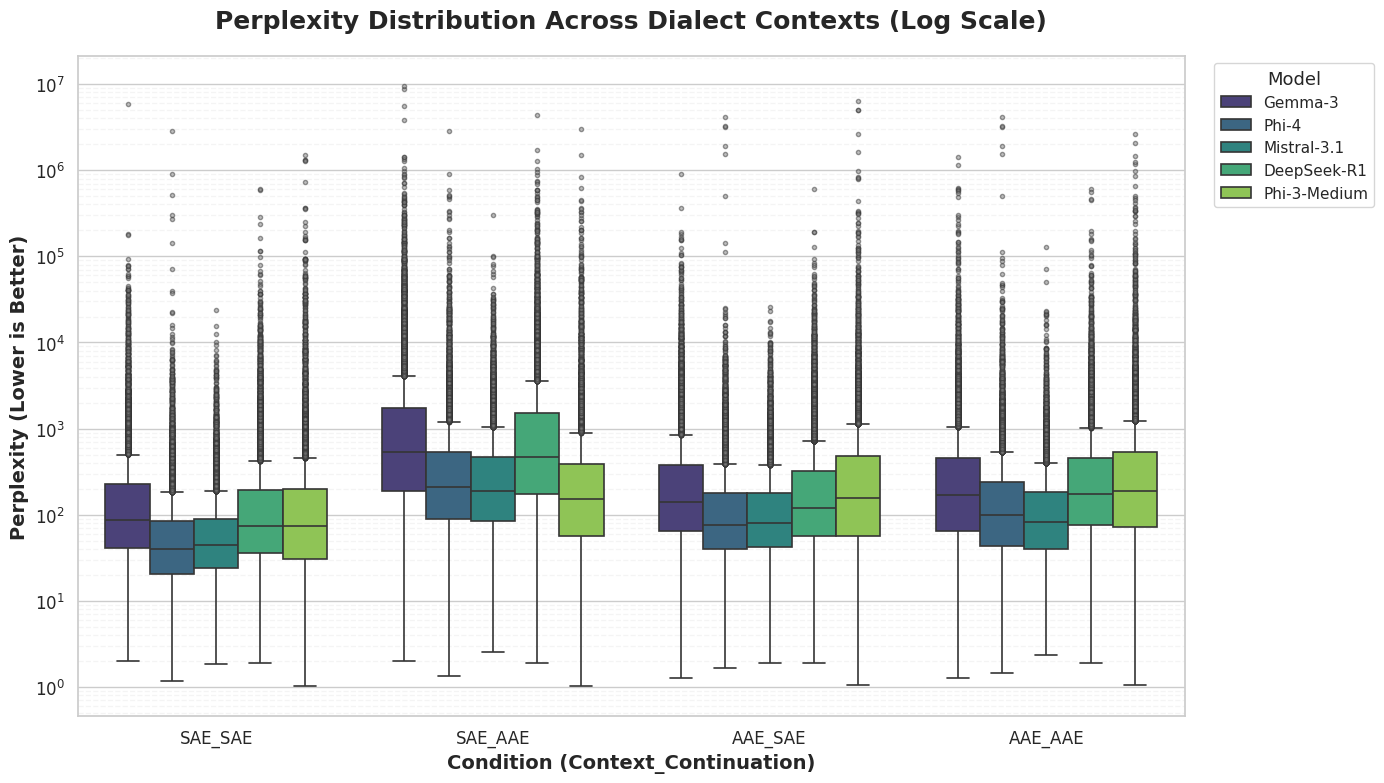

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. 数据准备部分
# ==========================================

# 请将此处的文件名替换为你实际的文件路径
# 假设每个模型对应一个 CSV 文件
model_files = {
    'Gemma-3': 'gemma3-results/ppl_scores_long.csv',
    'Phi-4': 'phi4-results/ppl_scores_long.csv',
    'Mistral-3.1': 'mistral31-results/ppl_scores_long.csv',
    'DeepSeek-R1': 'deepseekr1-results/ppl_scores_long.csv',
    'Phi-3-Medium': 'phi3-medium-results/ppl_scores_long.csv'
}

data_frames = []

# 循环读取每个文件并打上标签
for model_name, file_path in model_files.items():
    try:
        # 读取 CSV
        df = pd.read_csv(file_path)
        
        # 确保包含我们需要的列
        if 'combo' in df.columns and 'ppl_cont' in df.columns:
            # 添加 'Model' 列，用于区分不同模型
            df['Model'] = model_name
            # 只保留需要的列以节省内存
            data_frames.append(df[['Model', 'combo', 'ppl_cont']])
        else:
            print(f"Warning: {file_path} 缺少 'combo' 或 'ppl_cont' 列")
            
    except FileNotFoundError:
        print(f"Error: 找不到文件 {file_path}，请检查路径")

# 合并所有模型的数据
if data_frames:
    full_data = pd.concat(data_frames, ignore_index=True)
    print(f"成功加载数据，共 {len(full_data)} 行。")

    # ==========================================
    # 2. 绘图部分
    # ==========================================
    
    # 设置绘图风格
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(14, 8))

    # 定义 X 轴的显示顺序，让故事线更清晰
    # 1. SAE基准 -> 2. SAE转AAE (变差?) -> 3. AAE转SAE (纠正?) -> 4. AAE保持 (理想?)
    combo_order = ['SAE_SAE', 'SAE_AAE', 'AAE_SAE', 'AAE_AAE']

    # 绘制 Box Plot
    plot = sns.boxplot(
        data=full_data,
        x='combo',
        y='ppl_cont',
        hue='Model',
        order=combo_order,      # 强制指定X轴顺序
        palette='viridis',      # 学术常用的配色
        showfliers=True,        # 显示离群点 (Outliers)，这对展示模型不稳定性很重要
        linewidth=1.2,
        flierprops={"marker": "o", "markersize": 3, "alpha": 0.5, "markerfacecolor": "gray"} # 优化离群点样式
    )

    # *** 关键 ***：设置 Y 轴为对数坐标
    # 因为截图显示有些 PPL 高达 100,000+ (outliers)，线性坐标会让箱子看不见
    plot.set_yscale("log")

    # ==========================================
    # 3. 美化与标注
    # ==========================================
    
    plt.title('Perplexity Distribution Across Dialect Contexts (Log Scale)', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Condition (Context_Continuation)', fontsize=14, fontweight='bold')
    plt.ylabel('Perplexity (Lower is Better)', fontsize=14, fontweight='bold')
    
    # 调整刻度字体
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # 优化图例位置，放在图外以免遮挡数据
    plt.legend(title='Model', title_fontsize='13', fontsize='11', bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.grid(True, which="minor", ls="--", alpha=0.2) # 增加细网格方便读数
    plt.tight_layout()
    
    # 保存图片
    plt.savefig('perplexity_boxplot_final.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("未加载任何数据，请检查文件路径。")